# Formalia:

Please read the [assignment overview page](https://github.com/lalessan/comsocsci2022/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday, April 5th at 23:55. Hand in your Jupyter notebook file (with extension `.ipynb`) via DTU Learn _(Course Content, Assignemnts, Assignment 2)_


Remember to include in the first cell of your notebook:
* the link to your group's Git repository
* group members' contributions

## Part 1: TF-IDF

For this exercise, you need the following data: 
* The r/wallstreetbets submissions (either the one provided by me [here](https://github.com/lalessan/comsocsci2021/blob/master/data/wallstreet_subs.csv.gz) or the one you downloaded in Week 6).
* The list of 15 stocks you identified in Week 6, Exercise 2.

In [2]:
# Prelude for the assignment.
import pandas as pd
import numpy as np
import re
from nltk import FreqDist
import matplotlib.pyplot as plt
import re, string, unicodedata
import nltk
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

# Load text
wsb = pd.read_csv('../files/wallstreet_subs.csv')
wsb['text'] = [title + text for title,text in zip(wsb.title, wsb.selftext)]

# Get tickers
regex = r"\$([a-zA-Z]+)"
c_regex = re.compile(regex)

tickers = [c_regex.findall(text) for text in wsb.text]
tickers = [ticks for ticks in tickers if len(ticks) != 0]
tickers = np.hstack(np.array(tickers,dtype=object).flatten())

def upper(x):
    return x.upper()

tickers = np.vectorize(upper)(tickers)

# Helper functions for preprocessing
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def remove_URL(sample):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", sample)

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        if word.isdigit():
            continue
        else:
            new_words.append(word)
    return new_words


def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
    words = remove_stopwords(words)
    return words

def preprocess(sample):
    sample = remove_URL(sample)
    sample = replace_contractions(sample)
    # Tokenize
    words = nltk.word_tokenize(sample)

    # Normalize
    return normalize(words)

_Exercise_


> 1. Tokenize the __text__ of each submission. Create a column __tokens__ in your dataframe containing the tokens. Remember to follow the instructions in Week 6, Exercise 3.  

In [3]:
wsb['tokens'] = [preprocess(text) for text in wsb.text]

> 2. Find submissions discussing at least one of the top 15 stocks you identified above (follow the instructions in Week 6, Exercise 3).

In [5]:
freq = FreqDist(tickers)
freq = list(freq.items())
freq.sort(reverse=True,key=lambda x: x[1])

N = 15

company_names = ['SPDR S&P 500 ETF Trust','Tesla', 'Virgin Galactic', 'Microsoft', 'Palantir Technologies',
                  'Rope', 'Apple', 'Amazon', 'Zoom Video Communications','Nio Inc', 'Alibaba Group',
                 'Advanced Micro Devices', 'Gamestop', 'Boeing', 'The Walt Disney Company']

n_tickers = [tick[0].lower() for tick in freq[:N]]
dict_ticker = dict(zip(n_tickers,n_tickers))
dict_name = dict(zip([name.lower() for name in company_names],n_tickers))           
                   
def intersection(tokens):
    I = []
    for token in tokens:
        tick = dict_ticker.get(token)
        name = dict_name.get(token)
        if tick is not None:
            I.append(tick.upper())
        elif name is not None:
            I.append(name.upper())
    return I

wsb['stock'] = [list(set(intersection(token))) for token in wsb.tokens]

wsb_exp1 = wsb.explode('stock')
wsb_exp1.stock = np.array([ x if type(x) == str else 'OTHER' for x in wsb_exp1.stock.values])

A sample of the submissions for SPY

In [30]:
j = 0
for i, tick in enumerate(wsb_exp1.stock):
    if tick == 'SPY':
        print(wsb_exp1.text[i])
        j+=1
    if j == 5:
        break

9    SPY PREDICTION- I'M 100% SURE THAT I MIGHT BE ...
9    SPY PREDICTION- I'M 100% SURE THAT I MIGHT BE ...
Name: text, dtype: object
YouTube fraud?So I've seen many youtubers turning $5 into $1000 trading forex. Are they legit? Not the method, I mean do brokers even allow to trade with such low deposits?
My doomsday prediction for Aprilhello fellow autists,

as most of you don't know i am making doomsday predictions since december as a perma🐻. i regretfully read your posts about there is no bad news left. well i have some disgusting bearish material for ya dirty ass scumbag motherfuckers.

my doomsday prediction for april: cases resurges in china as they try to return back to normal. world realizes it's not possible to return back to normal without a vaccine or killing millions of people to get herd immunity. markets apparently fucked. stupid funds who bought the dip in the past few weeks try to hedge with short-term puts more agressively. which exacarbates the freefall. markets plu

> 3. Now, we want to find out which words are important for each *stock*, so we're going to create several ***large documents, one for each stock***. Each document includes all the tokens related to the same stock. We will also have a document including discussions that do not relate to the top 15 stocks.

In the following `not_doc` is the document, which contains all the tokens not relating to the top 15 stocks.

`token_ticker` is a dictionary of documents, one for each ticker, which contains all the tokens, which relate to the key/ticker.

In [6]:
idx = []
for key, item in enumerate(wsb_exp1['stock'].values):
    if item == 'OTHER':
        idx.append(key)
idx = np.array(idx)

not_doc = []
for i in idx:
    not_doc += wsb_exp1.tokens.values[i]


not_doc

['fed',
 'actually',
 'buying',
 'okay',
 'may',
 'actually',
 'retarded',
 'defense',
 'everyone',
 'said',
 'fed',
 'buying',
 'corporate',
 'paper',
 'buying',
 'lqd',
 'well',
 'lqd',
 'trading',
 'nav',
 'fucking',
 'day',
 'friday',
 'whole',
 'god',
 'damn',
 'day',
 'one',
 'buy',
 'push',
 'nav',
 'fed',
 'obviously',
 'buying',
 'bag',
 'shit',
 'retarded',
 'gay',
 'bear',
 'secondly',
 'fed',
 'said',
 'banks',
 'would',
 'ppp',
 'loans',
 'available',
 'last',
 'friday',
 'fuck',
 'thirdly',
 'states',
 'saying',
 'enough',
 'unemployment',
 'fourthly',
 'futures',
 'premarket',
 'thanks',
 'coming',
 'ted',
 'talk',
 'learn',
 'puts',
 'lazybeginning',
 'virus',
 'shit',
 'everyone',
 'talking',
 'puts',
 'rich',
 'googled',
 'puts',
 'like',
 'holy',
 'hell',
 'nobody',
 'got',
 'time',
 'thus',
 'get',
 'couple',
 'shares',
 'ignorance',
 'bliss',
 'reckon',
 'hot',
 'takeliterally',
 'everyone',
 'free',
 'time',
 'hands',
 'mean',
 'us',
 'autists',
 'means',
 'everyo

In [54]:
# The first 1000 tokens
" ".join(not_doc)[:1000]

'fed actually buying okay may actually retarded defense everyone said fed buying corporate paper buying lqd well lqd trading nav fucking day friday whole god damn day one buy push nav fed obviously buying bag shit retarded gay bear secondly fed said banks would ppp loans available last friday fuck thirdly states saying enough unemployment fourthly futures premarket thanks coming ted talk learn puts lazybeginning virus shit everyone talking puts rich googled puts like holy hell nobody got time thus get couple shares ignorance bliss reckon hot takeliterally everyone free time hands mean us autists means everyone bored need find way make money boredom desperation lead lead hot take common man know stocks work look normie stock pages show stocks cheap buy stocks tldr stonks go fuck gordongordon believed even begin describe disappointed took shit market supposed take red dildos ass dildo found morning green failed us portfolio find picturesomeone uploaded ohoto stock market history bull tra

In [7]:
n_tickers = [tick[0].lower() for tick in freq[:]]
dict_ticker = dict(zip(n_tickers,n_tickers))
                             
def intersection_common(tokens):
    I = []
    for token in tokens:
        tick = dict_ticker.get(token)
        if tick is not None:
            I.append(tick.upper())
    return I

ticker_occurance = [list(set(intersection_common(token))) for token in wsb.tokens]

wsb_exp2 = wsb.copy()
wsb_exp2.stock = ticker_occurance
wsb_exp2 = wsb_exp2.explode('stock')

token_ticker = {tick: [] for tick in tickers}

for i, tick in enumerate(wsb_exp2.stock.values):
    if type(tick) == str:
        token_ticker[tick] += wsb_exp2.tokens.values[i]

> 4. Now, we're ready to calculate the TF for each word. Find the top 5 terms within __5 stocks of your choice__. 
>   * Describe similarities and differences between the stocks.
>   * Why aren't the TFs not necessarily a good description of the stocks?
>   * Next, we calculate IDF for every word. 
>   * What base logarithm did you use? Is that important?

In [16]:
five_tickers = [tick[0].upper() for tick in freq[:5]]
five_tickers

['SPY', 'TSLA', 'SPCE', 'MSFT', 'PLTR']

In [17]:
def term_freq(document):
    #terms = set(document)
    #tf = np.zeros(len(terms))
    f = FreqDist(document)
    f = list(f.items())
    f.sort(reverse=True,key=lambda x: x[1])
    s = sum([x[1] for x in f])
    f = {x[0]: x[1]/s for x in f}
    return f

tf = {}
for tick in five_tickers:
    tf.update({tick: term_freq(token_ticker[tick])})

In [23]:
for tick in five_tickers:
    print(f"The top 5 terms for {tick} are: {[key for key in list(tf[tick].keys())[:5]]}")

The top 5 terms for SPY are: ['spy', 'market', 'puts', 'going', 'amp']
The top 5 terms for TSLA are: ['tsla', 'amp', 'stock', 'going', 'market']
The top 5 terms for SPCE are: ['spce', 'stock', 'going', 'gt', 'like']
The top 5 terms for MSFT are: ['msft', 'earnings', 'gt', 'spy', 'market']
The top 5 terms for PLTR are: ['pltr', 'buy', 'stock', 'going', 'like']


The top 5 terms are similar in that the name of the stock is the most frequent for each stock and for most the words `going, market, stock` are also included.
MSFT sticks out in that it is the only stock which includes the name of one of the other tickers, namely `spy`. This could be because Microsoft has the highest market value out of all the tickers, and thus may be more relavent to SPY.
Overall the top 5 terms are pretty similar, with the only unique words, beside the ticker names, being `buy, earnings, amp,puts` out of the 25 words.

The the top 5 terms selected by TF are not necessarily a good representation of the stock, because the words are based on reddit posts on WSB, which don't necessarily seek to describe what the stock is actually about, but rather might just be "mememy" content most of the time.

In [ ]:
def count_not_none(dicts, key):
    return sum([1 if d.get(key) is not None else 0 for d in dicts])

def inv_doc_term_freq(documents):
    n = len(documents)
    terms = []
    for d in documents:
        terms += d
    terms = set(terms)
    f = [FreqDist(d) for d in documents]
    idf = {t: np.log(n/count_not_none(f,t)) for t in terms}
    return idf

In [11]:
idf = inv_doc_term_freq([token_ticker[tick] for tick in five_tickers])

We use a natural base, which isn't important as all logarithms are simply a scaled version of each other and since we are looking at order scaling the numbers uniformly won't make any difference.

> 5. We're ready to calculate TF-IDF. Do that for the __5 stock of your choice__. 
>   * List the 10 top TF words for each stock.
>  * List the 10 top TF-IDF words for each stock.
>   * Are these 10 words more descriptive of the stock? If yes, what is it about IDF that makes the words more informative?

In [12]:
def tf_idf(tf, idf):
    tfidf = {}
    for d in tf.keys():
        tfidf.update({d: {}})
        for t in idf.keys():
            ftd = tf[d].get(t)
            if ftd is not None:
                tfidf[d].update({t: ftd * idf[t]})
    return tfidf

tfidf = tf_idf(tf,idf)
sorted_words = {d: sorted(tfidf[d].items(), key=lambda x: x[1],reverse=True) for d in tfidf.keys()}

In [26]:
for tick in five_tickers:
    print(f"The top 10 terms for {tick} are: {[key[0] for key in sorted_words[tick][:10]]}\n")

The top 10 terms for SPY are: ['____________________', '_____________________', 'yachty', 'reinfection', 'retardstime', 'reinfections', 'flu', 'whalemovement', '220p', 'r0']

The top 10 terms for TSLA are: ['botfuck', 'ua', 'manganese', 'fsd', 'nand', 'baron', 'filler', 'next_day_return', 'mobileye', 'hvdc']

The top 10 terms for SPCE are: ['maxar', 'spaceflight', 'nimo', 'spaceport', 'nimotv', 'spaceshiptwo', 'vg', 'roflmao', 'non_market', 'hypersonic']

The top 10 terms for MSFT are: ['next_day_return', 'jedi', 'cvm', 'macrohard', 'azure', 'webex', '__________________', 'x1000', 'whisper', 'x5000']

The top 10 terms for PLTR are: ['apxt', 'shitron', 'saruman', 'ssss', 'coster', 'sumo', 'gandalf', 'mithril', 'foundry', 'non_market']



The top 10 words, do not seem more descriptive of the stock, but rather more descriptive of how WSB's discourse about the stock is. Most of it seems to be jargon or slang, and some numbers, which escaped the text filtering. 

The reason for IDF not making the words more informative could be that across all the stocks slang is the most prevalent and thus since slang is commonly used to talk about each of the stocks it is what shows up. There also seems to be some stock specific slang, which could be weighted higher, since there is nothing keeping a redditor from talking about a different stock in the comment section on a post about another stock.

> 6. Visualize the results in a Wordcloud and comment your results (follow the instrutions in Week 6, Exercise 4). 

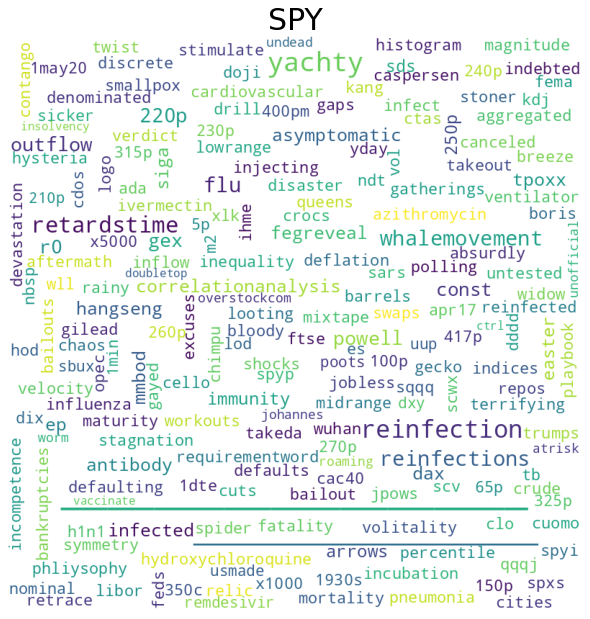

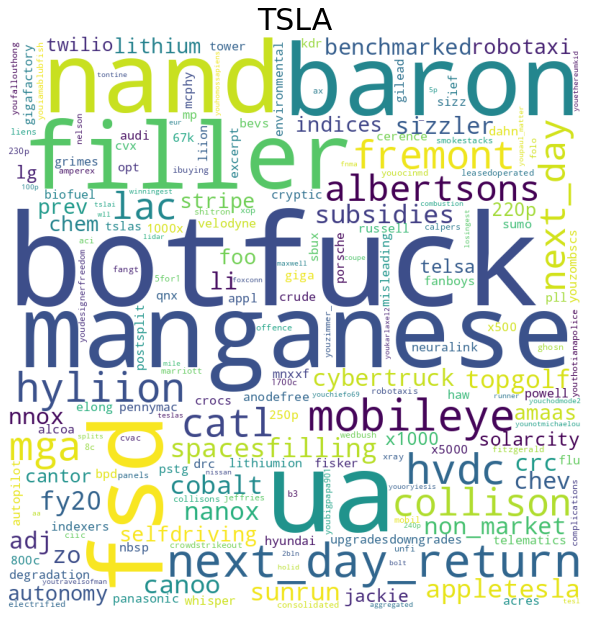

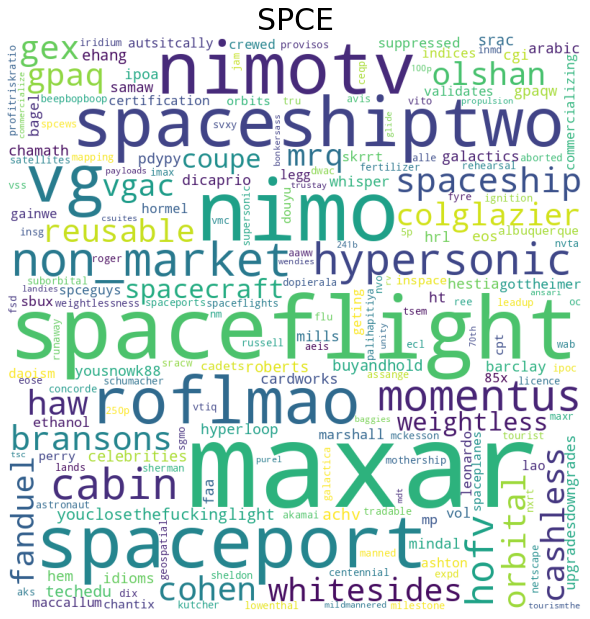

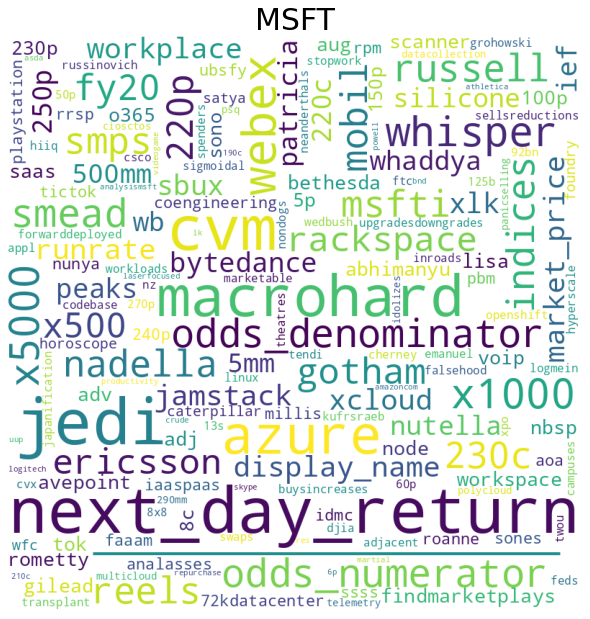

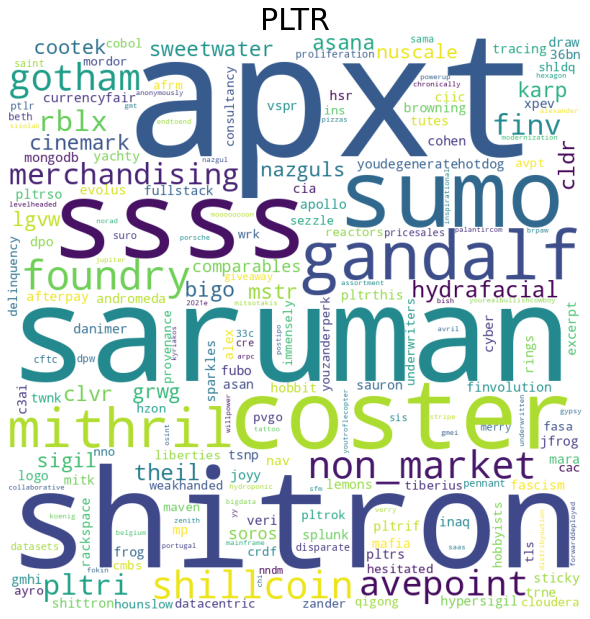

In [14]:
from wordcloud import WordCloud

for tick in five_tickers:
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = "",
                    min_font_size = 10).generate_from_frequencies(tfidf[tick])

    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(tick, fontsize=30)
    plt.show()
    plt.close()

### The following plots are not part of the assignment, but seemed more informative, but are only wordclouds based on frequency.

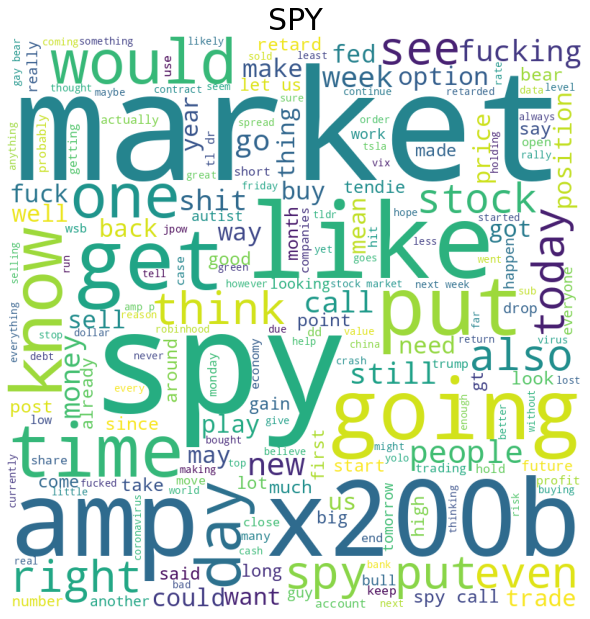

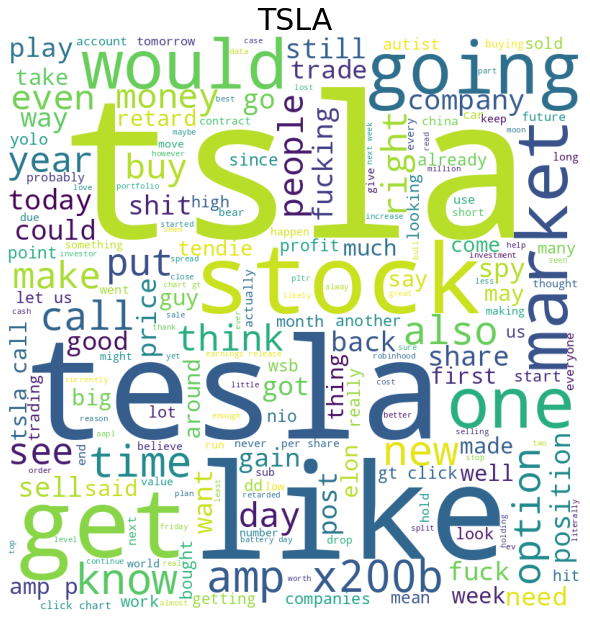

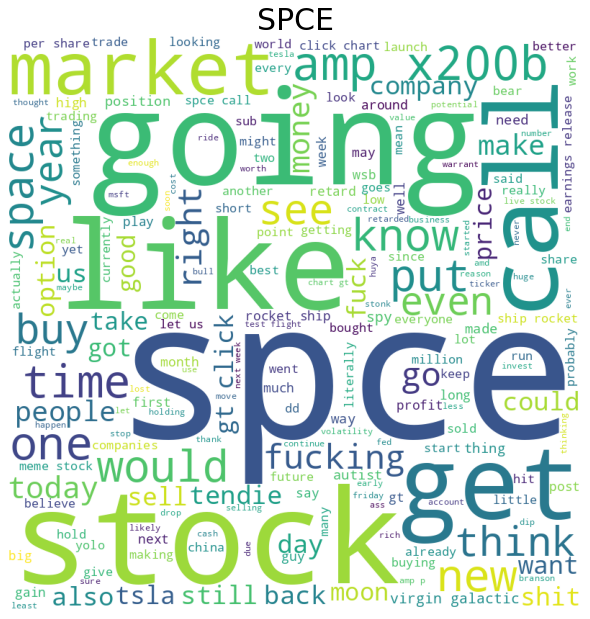

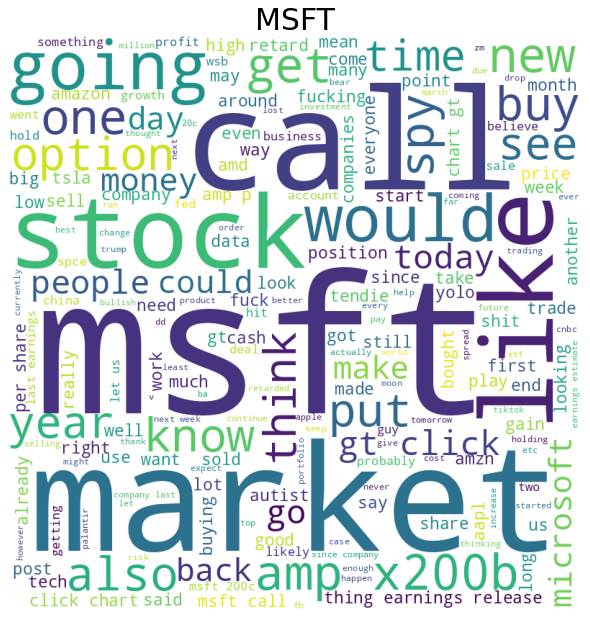

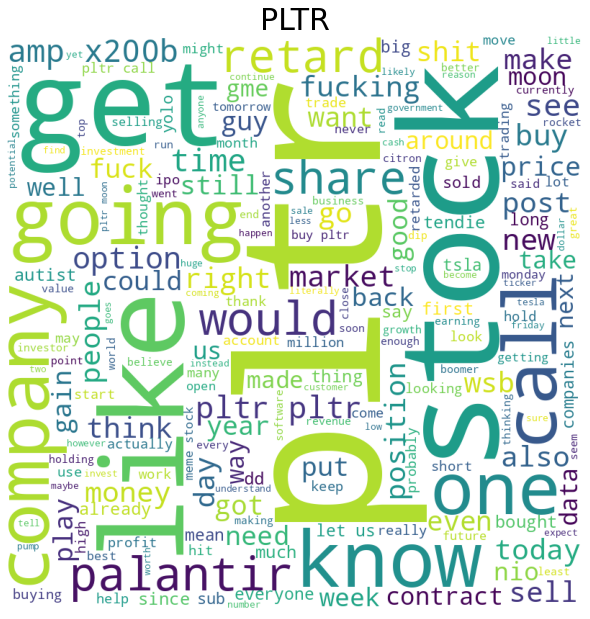

In [15]:
for tick in five_tickers:
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = "",
                    min_font_size = 10).generate(" ".join(token_ticker[tick]))

    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(tick, fontsize=30)

    plt.show()
    plt.close()

## Part 2: Sentiment analysis

In [33]:
import pandas as pd
import matplotlib.dates as mdate
from scipy.stats import pearsonr
from scipy import stats
import matplotlib.pyplot as plt
import re
import datetime as datetime
from collections import Counter

data = wsb.copy()

# Some preprocessing: converting utc to datetime
data['date'] = [datetime.datetime.fromtimestamp(ts) for ts in data['created_utc']]
data['date'] = data['date'].dt.date
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace = True)

_Exercise: Creating Word Shifts_
>    1. Pick a day of your choice in 2020. We call it $d$. It is more interesting if you pick a day where you expect something relevant to occur (e.g. Christmas, New Year, Corona starting, the market crashes...).

We picked Christmas day (25th of December), since it seems reasonable to assume that this will be a day with relatively positive sentiment. 

In [ ]:
d = '2020-12-25'
d = data.loc[d].index[0] # This returns '2020-12-25 00:00:00'

>    2. Build two lists $l$ and $l_{ref}$ containing all tokens for submissions posted on r/wallstreebets on day $d$, and in the 7 days preceding day $d$, respectively. 

In [37]:
d_min = d - datetime.timedelta(days=7)
print(f"The 7th day preceeding {d} is {d_min}")

The 7th day preceeding 2020-12-25 00:00:00 is 2020-12-18 00:00:00


In [38]:
# This line is not neccesary to run, since we have already preprocessed tokens in the previous step
data['tokens'] = [preprocess(text) for text in data.text]

In [39]:
l = np.ndarray.tolist(np.concatenate(data.loc[d]['tokens']))

l_ref = []
date = d_min
while date <= d:
    l_ref.append(np.concatenate(data.loc[date]['tokens']))
    date += datetime.timedelta(days=1)
l_ref = [item for sublist in l_ref for item in sublist]

>    3. For each token $i$, compute the relative frequency in the two lists $l$ and $l_{ref}$. We call them $p(i,l)$ and $p(i,l_{ref})$, respectively. The relative frequency is computed as the number of times a token occurs over the total length of the document. Store the result in a dictionary.

Computing the relative frequencies of $l$ and $l_{ref}$ and storing them in $\textit{two}$ dictionaries for ease of use

In [42]:
p = dict([(item[0],item[1]/len(l)) for item in Counter(l).items()])
p_ref = dict([(item[0],item[1]/len(l_ref)) for item in Counter(l_ref).items()])

>    4. For each token $i$, compute the difference in relative frequency $\delta p(i) = p(i,l) - p(i,l_{ref})$. Store the values in a dictionary. Print the top 10 tokens (those with largest relative frequency). Do you notice anything interesting?

In [43]:
all_tokens = set(p.keys()).union(set(p_ref.keys()))
dp = dict([(token, p.get(token,0) - p_ref.get(token,0)) for token in all_tokens])
sorted(dp.items(), key = lambda x:x[1], reverse = True)[:10]

[('christmas', 0.002614861335288132),
 ('gme', 0.002216868630337651),
 ('cerner', 0.0019833800219576296),
 ('like', 0.0019112728829128837),
 ('merry', 0.0017217928494443586),
 ('money', 0.001623914236669896),
 ('make', 0.001493296670195811),
 ('robinhood', 0.0011275674840683734),
 ('margin', 0.0010813690053055164),
 ('get', 0.001065367536825821)]

Unsurprisingly ‘Christmas’ and ‘Merry’ are among the words with the largest relative frequency. However, it is more interesting to see that ‘gme’ (referring to the GameStop stocks) is among the top 10. As we know, the GME stock rose exponentially in the month of January 2021 and seeing it high on this relative frequency list can in retrospect be seen as an early sign of this.

>    5. Now, for each token, compute the happiness $h(i) = labMT(i) - 5$, using the labMT dictionary. Here, we subtract $5$, so that positive tokens will have a positive value and negative tokens will have a negative value. Then, compute the product $\delta \Phi = h(i)\cdot \delta p(i)$. Store the results in a dictionary. 

In [44]:
labMt_dict = pd.read_csv("../files/Hedonometer.csv")
labMt_dict = labMt_dict.set_index("Word")

In [45]:
h = dict([(token, labMt_dict["Happiness Score"].get(token,np.nan)-5) for token in all_tokens])

In [46]:
dPhi = dict([(token,h[token]*dp[token]) for token in all_tokens if not np.isnan(h[token])])

>    6. Print the top 10 tokens, ordered by the absolute value of $|\delta \Phi|$. Explain in your own words the meaning of $\delta \Phi$. If that is unclear, have a look at [this page](https://shifterator.readthedocs.io/en/latest/cookbook/weighted_avg_shifts.html).

In [47]:
sorted(dPhi.items(), key = lambda x:np.abs(x[1]), reverse = True)[:10]

[('christmas', 0.00773998955245287),
 ('merry', 0.004407789694577557),
 ('like', 0.004243025800066602),
 ('money', 0.0037350027443407608),
 ('million', -0.002570742154626264),
 ('market', -0.002140840017328303),
 ('covid', 0.001709496434070027),
 ('rich', 0.001584659212083947),
 ('growth', -0.0015538855101833154),
 ('today', -0.0015226368669873504)]

$\delta p$ denotes the change in word occurrences from the prior 7 days compared to the chson day. 

$h(i)$ denotes the happiness of a given word. 

As such, $\delta  \Phi$ denotes the change in happiness a given word contributes for the final day compared to the prior 7 days - i.e. it denotes the change in impact of the words.

>    7. Now install the [``shifterator``](https://shifterator.readthedocs.io/en/latest/installation.html) Python package. We will use it for plotting Word Shifts. 

>    8. Use the function ``shifterator.WeightedAvgShift`` to plot the WordShift, showing which words contributed the most to make your day of choice _d_ happier or more sad then days in the preceding 7 days. 

In [48]:
import shifterator as sh

In [49]:
sentiment_sh = sh.WeightedAvgShift(type2freq_1=p_ref,
                    type2freq_2=p,
                    type2score_1 = 'labMT_English',
                    reference_value=5)

/home/kjb/python-venvs/dtu-signaler-data/lib/python3.8/site-packages/shifterator/plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


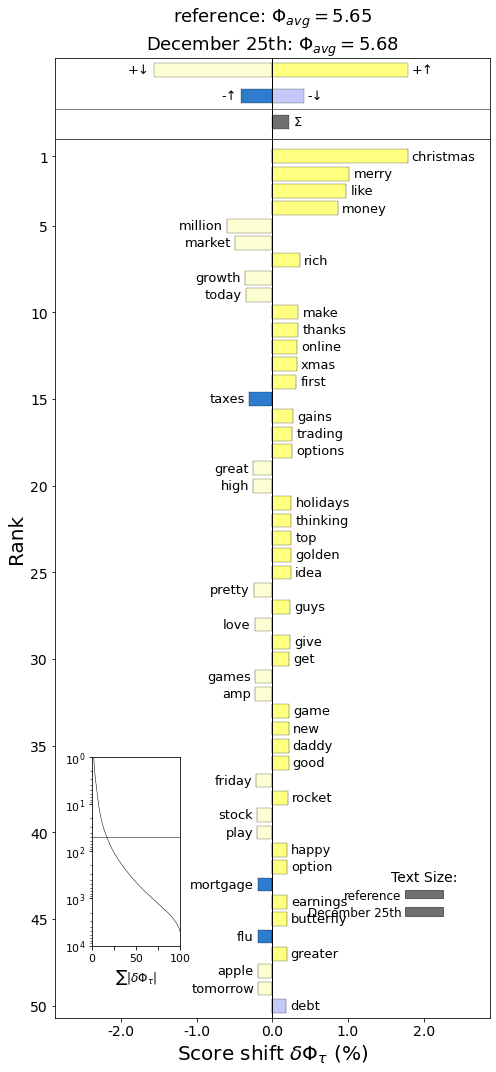

In [52]:
sentiment_sh.get_shift_graph(detailed= True,
                            system_names = ['reference', 'December 25th'])
plt.show()
plt.close()

The figure shows that words like “christmas”, “merry”, “like” and “money” are positive words that unsurprisingly occurred more often and thereby contributed to December 25th being a date with more positive sentiment than the reference period of 7 days before this date. 

Interestingly we see that the word “market” is considered a positive word and that it occurred less often, which subtracts from the higher positive sentiment score of December 25th. This is interesting firstly partly because it is revealing of the values of the people whose scoring was used to make the sentiment lexicon (i.e. they are liberal). Secondly, it is interesting because it shows that users on wallstreetbets used the word “market” less on Christmas day. This indicates that they were less focused on the core topic of the subreddit (trading stocks) and instead spent more words on social conversations in wishing each other “Merry Christmas”.

There are only minor differences in negative words being used more (“flu”) or less (“debt”) often. As such, it is primarily the difference in usage of positive words that contributed to the 25th of December being a day with more positive sentiment.

>    9. How do words that you printed in step 6 relate to those shown by the WordShift? 

They are basically identical but for the fact that “covid” does not appear in the WordShift but appears in exercise 6. The ordering of the two are also identical.

The great similarity makes sense, as the two methods are essentially the same. 


## Part 3: Communities for the Zachary Karate Club Network

_Exercise: Zachary's karate club_: In this exercise, we will work on Zarachy's karate club graph (refer to the Introduction of Chapter 9). The dataset is available in NetworkX, by calling the function [karate_club_graph](https://networkx.org/documentation/stable//auto_examples/graph/plot_karate_club.html) 

> 1. Visualize the graph using [netwulf](https://netwulf.readthedocs.io/en/latest/). Set the color of each node based on the club split (the information is stored as a node attribute). My version of the visualization is below.
>

In [28]:
import networkx as nx
import netwulf as nw
G = nx.karate_club_graph()

In [29]:
for k, v in G.nodes(data=True):
    v['group'] = v['club']; del v['club']

In [27]:
nw.visualize(G)

<img src="https://raw.githubusercontent.com/DrJupiter/Public-images/main/a2p3n1.png" alt="Drawing" style="width: 800px;"/>

> 2. Write a function to compute the __modularity__ of a graph partitioning (use **equation 9.12** in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.

$$M = \sum_{c=1}^{n_{c}} \Bigg(\frac{L_{c}}{L} -\bigg(\frac{k_{c}}{2 \cdot L}\bigg)^{2}\Bigg) $$

$L_c$ = Total number of links withink a community $c$.

$k_c$ = Total degree of the nodes in a community $c$

$L$ = Total number of links/edges in the network

In [ ]:
def modularity(graph, community_partitions):

    # Assuming undirected graph
    degree_dict = dict(graph.degree())
    L = sum(degree_dict.values())/2
    div = 1/(2*L)**2
    
    def community_term(community):
        k_c = sum([degree_dict[node] for node in community])
        L_c = sum([1 for u, v in graph.edges(community) if v in community])
        return L_c/L - k_c**2 * div

    return sum(map(community_term, community_partitions))

# Create group partitions
import numpy as np
groups = np.unique(list(nx.get_node_attributes(G,'group').values()))
partitions = {g: [] for g in groups}

for node, group in nx.get_node_attributes(G,'group').items():
    partitions[group].append(node)

partitions = list(partitions.values())

> 3. Explain in your own words the concept of _modularity_. 

The modularity describes whether the network is more inter or outer connected, since if the network has as many ingoing connections to the group as outgoing then $k_c = L_c \cdot 2$ and M = 0. If M is positive it is because it is more interconnected than outer connected.
Thus M can somewhat be seen as a relative density measure, where the relativeness is rooted in the group connections contra the outer connections.

> 4. Compute the modularity of the Karate club split partitioning using the function you just wrote. Note: the Karate club split partitioning is avilable as a [node attribute](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.classes.function.get_node_attributes.html), called _"club"_.

In [142]:
MM = modularity(G,partitions)
print(f"The modularity is: {MM:.5f}")

The modularity is: 0.35823


> 5. We will now perform a small randomization experiment to assess if the modularity you just computed is statitically different from $0$. To do so, we will implement the _double edge swap_ algorithm. The _double edge swap_ algorithm is quite old... it was implemented in 1891 (!) by Danish mathematician Julius Petersen(https://en.wikipedia.org/wiki/Julius_Petersen). Given a network G, this algorithm creates a new network, such that each node has exactly the same degree as in the original network, but different connections. Here is how the algorithm works.
>       * __a.__ Create an identical copy of your original network.
>       * __b.__ Consider two edges in your new network (u,v) and (x,y), such that u!=v and v!=x.
>       * __c.__ If none of edges (u,y) and (x,v) exists already, add them to the network and remove edges (u,v) and (x,y).
>       * Repeat steps __b.__ and __c.__ to achieve at least N swaps (I suggest N to be larger than the number of edges).

In [157]:
def double_edge_swap(graph, N):
    Gp = graph.copy()
    for i in range(N):
        E  = np.array(list(Gp.edges()))
        r = np.random.randint(len(E),size=(2,))
        u, v = E[r[0]] 
        x, y = E[r[1]]
        if u != v and v!= x:
            if Gp.has_edge(u,y) or Gp.has_edge(x,v):
                continue
            else:
                Gp.remove_edge(u,v)
                Gp.remove_edge(x,y)
                Gp.add_edge(u,y)
                Gp.add_edge(x,v)
    return Gp   

> 6. Double check that your algorithm works well, by showing that the degree of nodes in the original network and the new 'randomized' version of the network are the same.

In [137]:
sum(dict(G.degree()).values()) == sum(dict(double_edge_swap(G,100).degree()).values())

True

> 7. Create $1000$ randomized version of the Karate Club network using the _double edge swap_ algorithm you wrote in step 5. For each of them, compute the modularity of the "club" split and store it in a list.

In [158]:
n = len(list(G.edges()))
G_1000 = [double_edge_swap(G,n+10) for _ in range(1000)]

> 8. Compute the average and standard deviation of the modularity for the random network.

In [159]:
def get_modularity(graph):
    groups = np.unique(list(nx.get_node_attributes(graph,'group').values()))
    partitions = {g: [] for g in groups}

    for node, group in nx.get_node_attributes(graph,'group').items():
        partitions[group].append(node)
    partitions = list(partitions.values())

    return modularity(graph,partitions)

mods = np.array([get_modularity(g) for g in G_1000])
print(f"The mean modularity is {np.mean(mods):.5f} and std is {np.std(mods,ddof=1):.5f}")

The mean modularity is 0.08016 and std is 0.04640


> 9. Plot the distribution of the "random" modularity. Plot the actual modularity of the club split as a vertical line (use [axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)). 

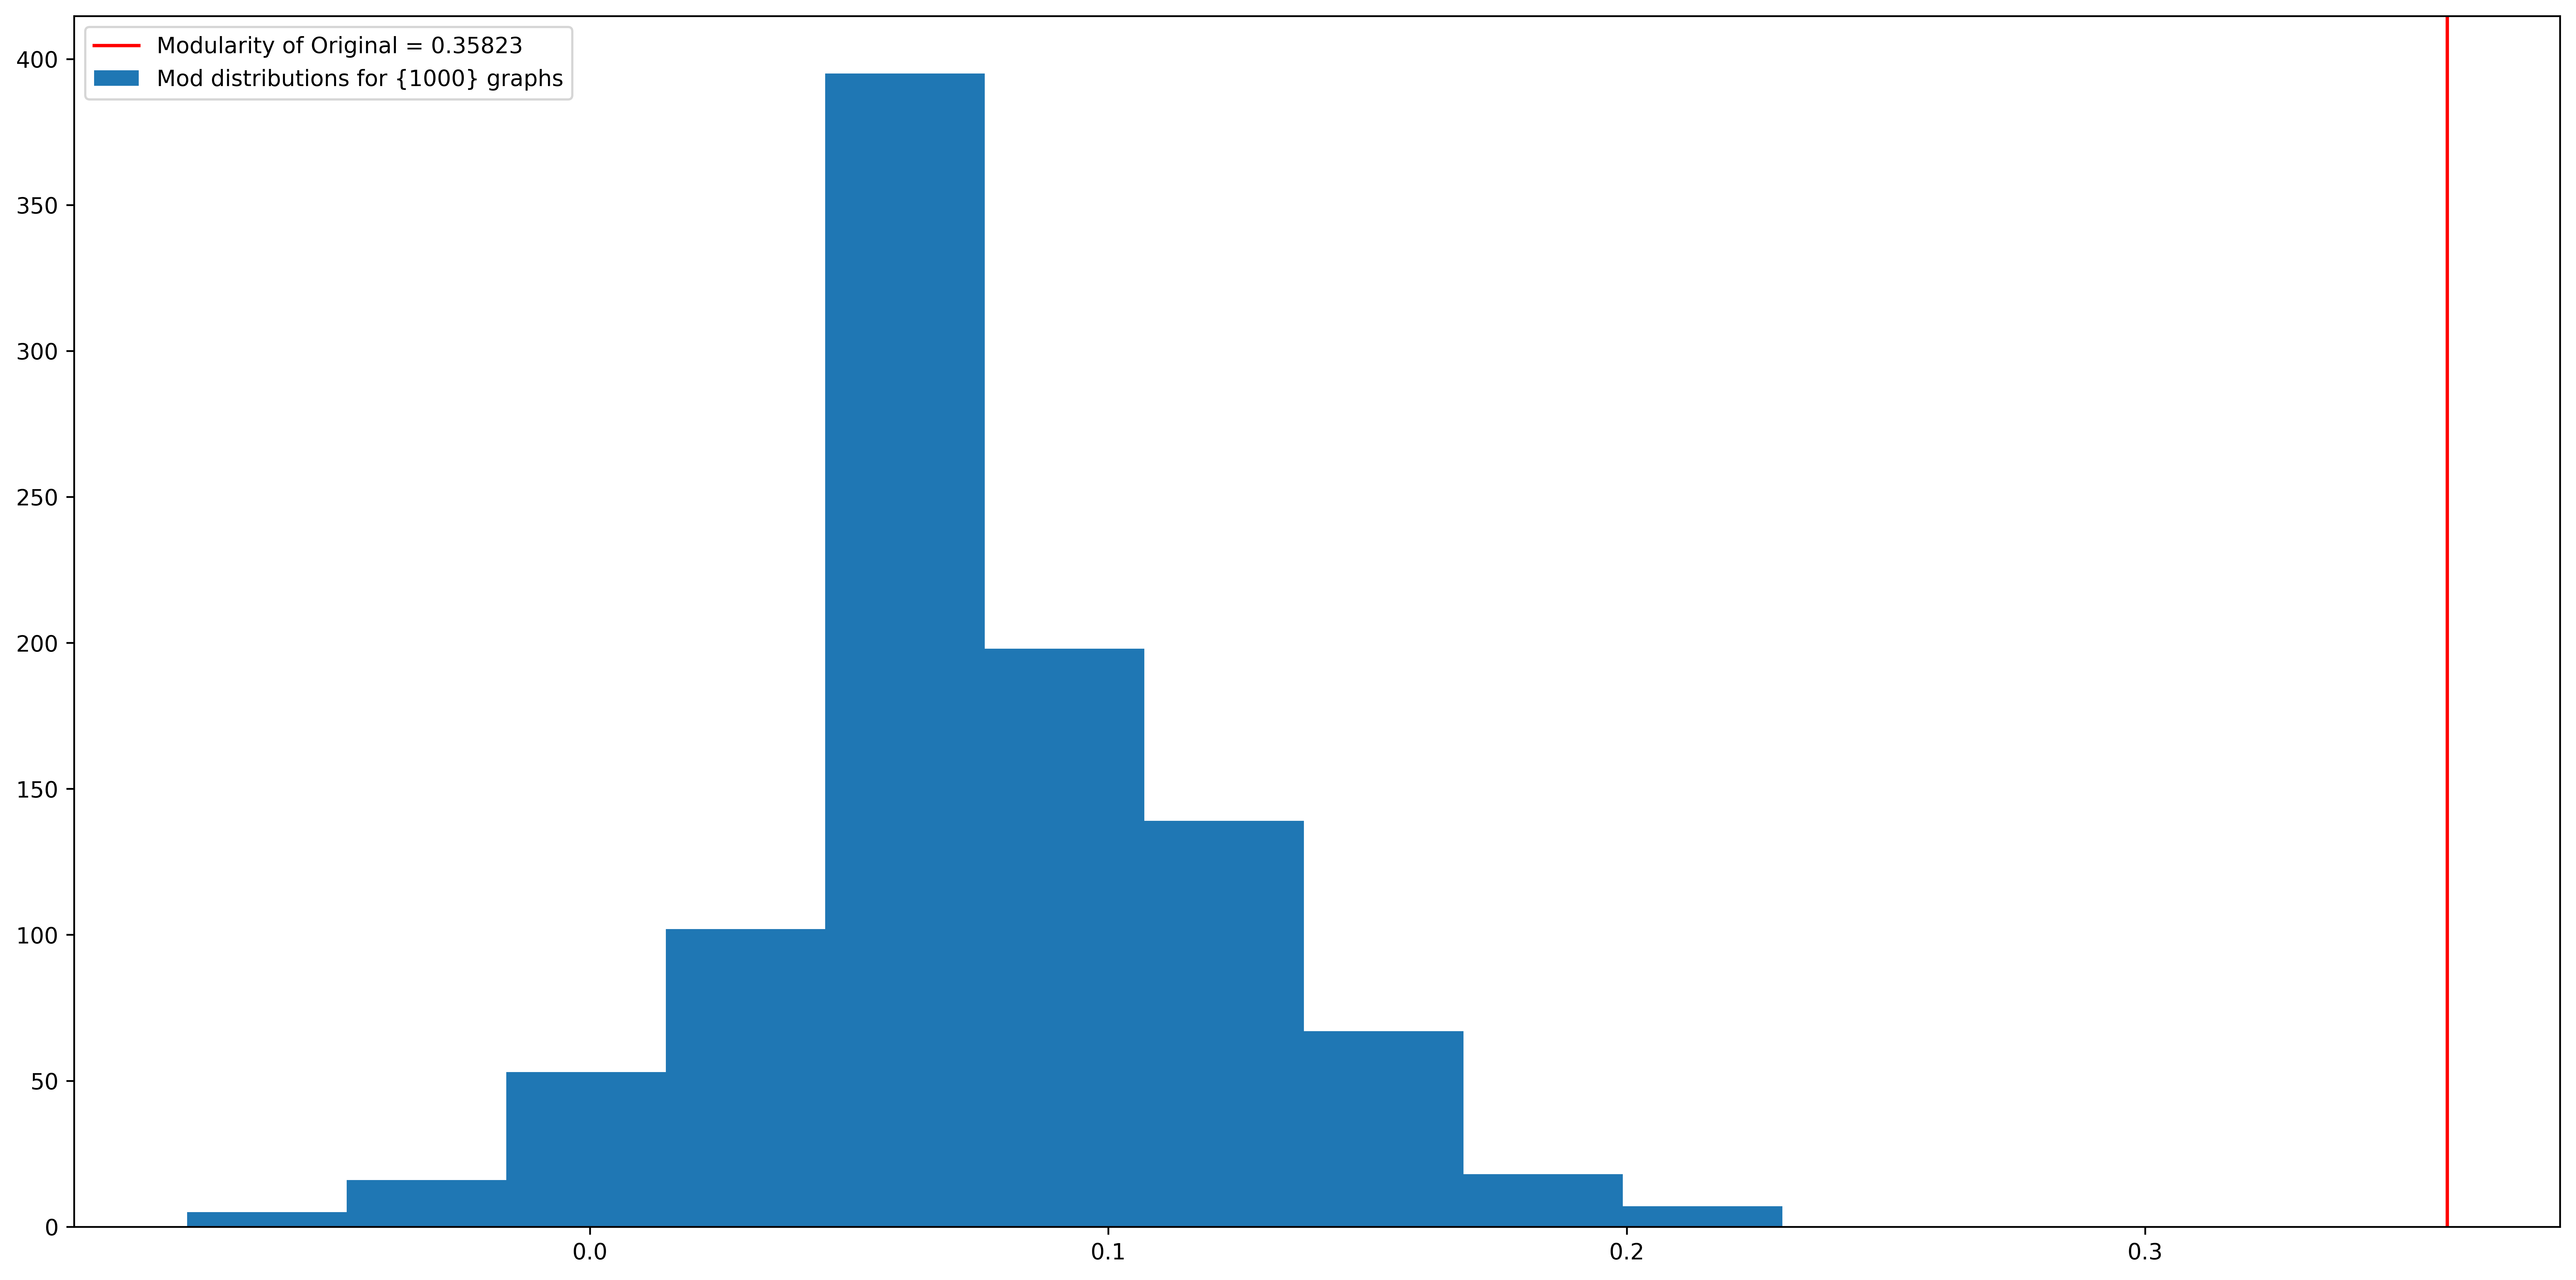

In [160]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10),dpi=600)
ax.hist(mods,label='Mod distributions for {1000} graphs')
ax.axvline(x=MM,color='r',label=f'Modularity of Original = {MM:.5f}')
ax.legend()
plt.show()
plt.close()

> 10. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to perform a randomization experiment? What is the reason why we preserved the nodes degree?

__(why randomize?)__
We compare the edges in the network to how they would fall at random in order get a measure for the level of "community" in the network. This the approach followed in the Newman-Girvan Algorithm. The idea here is to see whether the division of the network into communities results in a split where there are not only fewer, but _fewer than expected_ edges between the communities [Citation](https://www.pnas.org/doi/abs/10.1073/pnas.0601602103)

__(is it a good split?)__
Since the modularity of the group split is _significantly_ higher than the randomized networks (as is evident by it falling outside the range of two standard deviations of the normally distributed mean modularity of the random networks), it is arguably a good split. However, there might be even better splits , which is not something that this exercise investigated (but is investigated in problem 11)

__(why preserve degree?)__
Degree preserving randomization is used to ensure that all of the variation between the randomized experiments and the real-world network is due to differences in _degree distribution_ alone.

> 11.  Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?

In [222]:
import community as lou
lou_partition = lou.best_partition(G) 
lou_mod = lou.modularity(lou_partition,G)
print(f"The modularity of G based on the group partitions found by Lou is: {lou_mod:.5f}")
print(f"The Lou Modularity is greater than the previous modularity found: {lou_mod > MM}")

The modularity of G based on the group partitions found by Lou is: 0.41979
The Lou Modularity is greater than the previous modularity found: True


Since Lou creates paritions based on maximizing the modularity the comparison reveals that the modularity i.e the interconnection in the group relative to the outgoing connections from the group could be higher. 

> 12.  Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix **_D_** with dimension (2 times _A_), where _A_ is the number of communities found by Louvain. We set entry _D_(_i_,_j_) to be the number of nodes that community _i_ has in common with group split _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

In [217]:
# Construct confusion matrix
lou_groups = np.unique(list(lou_partion.values()))

lou_partitions = {g: [] for g in lou_groups}


for node, group in lou_partition.items():
    lou_partitions[group].append(node)

lou_partitions = list(lou_partitions.values())

cm = np.zeros((len(partitions),len(lou_groups)))

for i in range(len(partitions)):
    for j in range(len(lou_groups)):
        cm[i,j] = len([x for x in partitions[i] if x in lou_partitions[j]])

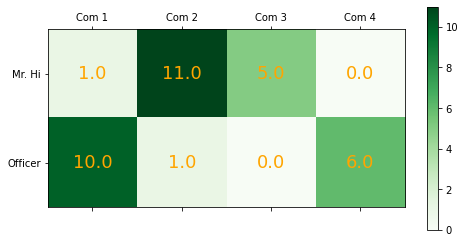

In [218]:
plt.matshow(cm,cmap=plt.cm.Greens)
plt.colorbar() 
for i in range(len(cm)):
        for j in range(cm.shape[1]):
            plt.annotate(cm[i,j],xy=(j,i),horizontalalignment='center',verticalalignment='center',size=18,color='orange') 
            
plt.xticks([0,1,2,3],labels=['Com 1','Com 2','Com 3','Com 4']) 
plt.yticks([0,1],labels=groups)
plt.show()

There are 34 members in total across both the groups, which each contain 17 members.
The Lou partions finds two groups which match 11 in the first group and 10 in the second group, which if chosen as the groups to represent the two orginal groups (Mr. Hi and Officer) then would lead to a partion accuracy of ($\frac{10 + 11}{34} \approx 61\%$).
Thus the communities found by Lou are far from perfect.

_Exercise: Community detection on the GME network._
> * Consider the GME network you built in [Week 4](https://github.com/lalessan/comsocsci2022/blob/main/lectures/Week4.ipynb), part 2.

In [59]:
import networkx as nx
import json
import re
from networkx.readwrite import json_graph

def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)


G_reddit = read_json_file('../files/json_graph.json')
G_reddit = G_reddit.to_undirected(reciprocal=True)

> * Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities. How many communities do you find? What are their sizes? Report the value of modularity found by the algorithm. Is the modularity significantly different than 0? 

In [72]:
reddit_lou_partition = lou.best_partition(G_reddit)
reddit_lou_groups = np.unique(list(reddit_lou_partition.values()))
print(f"The number of comminities found {len(reddit_lou_groups)}")

reddit_lou_partitions = {g: [] for g in reddit_lou_groups}


for node, group in reddit_lou_partition.items():
    reddit_lou_partitions[group].append(node)

# Is missing sig from 0 calculation

The number of comminities found 42021


In [73]:
print("The size of the first 1000 communities")

" ".join([str(len(group)) for group in reddit_lou_partitions.values()][:1000])

The size of the first 1000 communities


'1 302 1 149 643 209 299 1 4 1 407 366 407 361 1 498 252 1191 411 311 459 1 1 586 360 230 1 218 281 1 282 164 391 3 324 298 181 315 1 2 427 406 393 139 234 1 1 319 615 1 357 1162 1 403 279 260 186 119 313 267 352 310 406 217 2 1 1 1 1 1 278 1 1 90 309 302 1 308 2 1 251 1 1 1 1 1 1 278 258 1 1 1 1 1 1 1 1 2 3 1 1 1 421 1 1 1 1 1 1 1 1 2 2 1 1 1 1 1 2 1 2 1 1 1 248 71 1 1 3 1 1 1 1 1 1 1 1 212 1 1 1 1 1 1 1 1 1 339 1 2 1 118 1 2 1 161 2 1 1 1 1 1 310 1 1 1 1 1 1 1 2 134 226 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 220 1 1 207 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 186 1 1 1 3 1 2 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 52 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 98 1 1 1 1 1 2 2 1 1 1 1 1 2 1 1 1 1 2 3 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 44 1 1 2 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 

In [74]:
reddit_mod = lou.modularity(reddit_lou_partition,G_reddit)
print(f"The modularity of G based on the comminity partitions found by Lou is: {reddit_mod:.5f}")

The modularity of G based on the comminity partitions found by Lou is: 0.63158


We feel it doesn't make sense to calculate if our modularity result is significantly different from 0 as we only have one sample. Nor can we calculate it on the basis of the distribution of the individual terms in the sum, which makes up the modularity as we don't know their distribution.

> * Visualize the network, using netwulf (see Week 4). This time assign each node a different color based on their _community_. Describe the structure you observe.

In [67]:
reddit_lou_partition

{'------------------f': 0,
 'draconic86': 1,
 '----Zero----': 2,
 'grebfar': 3,
 '---LFC---': 4,
 'SignedUpWhilePooping': 5,
 'hofferd78': 6,
 'iloveitidontcare': 4,
 '---Tim---': 7,
 'seaybl': 8,
 '--Burt-Macklin-FBI--': 9,
 'FredBoi6363': 4,
 'Mrgumboshrimp': 10,
 'Rooty9': 11,
 'krush38': 12,
 '--Charizard--': 13,
 'gardeeon': 10,
 'powahTEN': 14,
 '--Clintoris--': 15,
 'AnnihilationGod': 16,
 'Character_Repair661': 17,
 'Terrifiedexistence': 18,
 'Unlucky-Prize': 15,
 'itsybitsyspida': 19,
 'scaryfawn8332': 20,
 '--Greg--': 21,
 'TitusSupremus': 22,
 '--Kestrel--': 23,
 'Chiskon': 24,
 'Edicez': 23,
 'MainlineX': 25,
 'Someonegreat7': 26,
 '--Kurwa--': 27,
 'BigFatCanadian': 28,
 'BuffaloWhip': 29,
 'Butthole--pleasures': 30,
 'CiceroJFaraday': 31,
 'DeadSol': 32,
 'JustGarrett': 27,
 'TadpoleCreative': 33,
 'dcao08': 27,
 'hidden_admin': 34,
 'joetheswede': 35,
 'stinkypoop12': 36,
 '--MilkMan--': 37,
 'somethingesque': 37,
 '--OZNOG--': 17,
 '-GregTheGreat-': 38,
 'OverwatchNWeed

In [70]:
for k, v in G_reddit.nodes(data=True):
    v['group'] = reddit_lou_partition[k];

({'xlim': [0, 680],
  'ylim': [0, 680],
  'linkColor': '#7c7c7c',
  'linkAlpha': 0.5,
  'nodeStrokeColor': '#555555',
  'nodeStrokeWidth': 0.6,
  'links': [{'source': 'draconic86',
    'target': 'ActuallyStephen',
    'width': 0.14342743312012723,
    'weight': 1},
   {'source': 'draconic86',
    'target': 'AlwaysOTM',
    'width': 0.14342743312012723,
    'weight': 1},
   {'source': 'draconic86',
    'target': 'CONNAN_MOCKASIN',
    'width': 0.202837021134844,
    'weight': 2},
   {'source': 'draconic86',
    'target': 'Comprehensive_Word23',
    'width': 0.14342743312012723,
    'weight': 1},
   {'source': 'draconic86',
    'target': 'DeadSol',
    'width': 0.14342743312012723,
    'weight': 1},
   {'source': 'draconic86',
    'target': 'HelpfulSocialist',
    'width': 0.14342743312012723,
    'weight': 1},
   {'source': 'draconic86',
    'target': 'MichaelVicksPitbull',
    'width': 0.14342743312012723,
    'weight': 1},
   {'source': 'draconic86',
    'target': 'NOSjoker21',
    'w

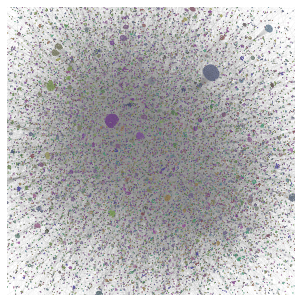

In [71]:
import netwulf as nw

nw.visualize(G_reddit)

<img src="https://raw.githubusercontent.com/DrJupiter/Public-images/main/a4p1n1.png" alt="Drawing" style="width: 800px;"/>

There are some communities, such as the dark blue one in the upper right corner, are bridged to the rest of the network by one user. This could be viewed as very active in the community, since it requires him or her to have recieved mutual interaction with all the other people in the community. Other than that the graph looks to consist of randomly scattered communities.

> Technical Note: The amount of comminities is very large and the amount of colors required is thus very large, thus there are some places where it can be a little hard to distinguish between closly colored communities.